Import various modules used in our analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.special import gammaincc,gammainccinv
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Import Covid-19 data from https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data'

In [2]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
us_data=pd.read_csv(url)

In [3]:
us_data = pd.read_csv('us_timeseries.csv') 

Analyze data

In [5]:
#list of the number of total cases in a county
all_Is = np.array([])
#list of the number of new cases in a county
all_dIs = np.array([])
#names of the counties
names = []
#number of days sampled 
days = 14
for i in range(len(us_data.iloc[:,0])):
    #Remove leading zeros so that data start when the first case is detected in that county
    n = np.trim_zeros(np.array(us_data.iloc[i,11:179].astype(str).astype(int)))
    
    #remove counties that show a decrease in total cases (indication of a reporting error) or don't last the number of days specified
    if np.all(np.diff(n)[:days] >= 0) and len(n)>days:
        cutoff = min(days, len(np.diff(n)))
        all_Is = np.append(all_Is,n[:cutoff])
        all_dIs = np.append(all_dIs,np.diff(n)[:cutoff])

mu = np.sum(all_dIs)/np.sum(all_Is)

Is = np.array([])
var = np.array([])
nums = np.array([])
means = np.array([])
num_new_cases = 0
num_active_cases = 0
for I in set(all_Is):
    #find all instances across all counties when there are I active cases
    indices = np.where(all_Is == I)[0]
    if len(indices) >= 250:
        dIs = all_dIs[indices]
        Is = np.append(Is, I)
        num_new_cases += np.sum(dIs)
        num_active_cases += I*len(indices)
        var = np.append(var,np.sum((dIs/I - np.mean(dIs/I))**2)/(len(indices)-1))
        means = np.append(means, np.mean(dIs/I))
        nums = np.append(nums,len(indices))
        
mu = num_new_cases/num_active_cases
v = np.sum(var*Is*nums)/np.sum(nums) - mu
disp = mu**2/v

In [6]:
print(mu,disp)

0.18451265563915495 0.09644454044816524


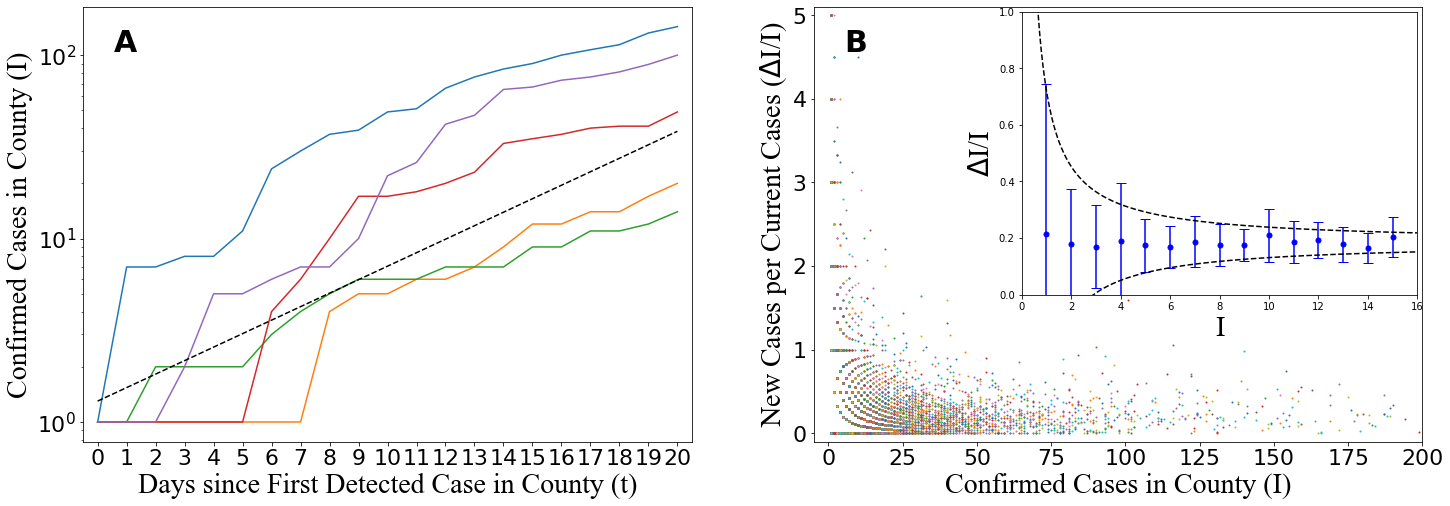

In [17]:
fig = plt.figure(figsize=(24, 8))
label = 'A'
ax = fig.add_subplot(1,2,1)
ax.text(0.05, 0.95, label, transform=ax.transAxes,fontsize=30, fontweight='bold', va='top')

counties = ["Boulder, Colorado","Mesa, Colorado","Jones, Georgia","Vanderburgh, Indiana","St. Mary, Louisiana"]

for county in counties:
    i = np.where(us_data.iloc[:,5]+', '+us_data.iloc[:,6] == county)[0][0]
    n = np.trim_zeros(np.array(us_data.iloc[i,11:].astype(str).astype(int)))[:21]
    ax.semilogy(n,'-')
    
ns = np.linspace(0,20,20)
ax.semilogy(ns,1.3*(1+mu)**ns,'k--')

ax.set_xticks(np.linspace(0,20,21))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
ax.set_xlabel("Days since First Detected Case in County (t)",fontsize = 28,fontname="Times New Roman")
ax.set_ylabel("Confirmed Cases in County (I)",fontsize = 28,fontname="Times New Roman")
ax.set_xlim(-0.5,20.5)



label = 'B'
ax = fig.add_subplot(1,2,2)
ax.text(0.05, 0.95, label, transform=ax.transAxes,fontsize=30, fontweight='bold', va='top')

for i in range(len(us_data.iloc[:,0])):    
    #Remove leading zeros so that data start when the first case is detected in that county
    n = np.trim_zeros(np.array(us_data.iloc[i,11:].astype(str).astype(int)))
    
    #remove counties that show a decrease in total cases (indication of a reporting error) or don't last the number of days specified
    if np.all(np.diff(n)[:days] >= 0):
        cutoff = min(days, len(np.diff(n)))
        ax.plot(n[:cutoff],np.diff(n)[:cutoff]/n[:cutoff],'.',ms = 2)
ax.set_xlim(-5,200)
ax.set_ylim(-0.1,5.1)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(22) 
    
inset_ax = inset_axes(ax, 
                    width="65%", # width = 30% of parent_bbox
                    height="65%", # height : 1 inch
                    loc=1)

inset_ax.errorbar(Is,means,yerr = var, color = 'b', marker='o', ms = 5,ls = '',capsize=5)
x = np.linspace(min(Is)-0.9,max(Is)+1,1000)
inset_ax.plot(x,mu+(mu+v)/x,'k--',label = r"$\mu_k \pm \frac{\mu_k+\sigma_k^2}{I}$")
inset_ax.plot(x,mu-(mu+v)/x,'k--')
inset_ax.errorbar([-10],[10],[1],marker = '',ls = '',capsize = 5,color = 'b',label = r"Var(I'/I)")
inset_ax.plot([-10],[10],'bo',label = r"Mean(I'/I)")
ax.set_xlabel("Confirmed Cases in County (I)",fontsize = 28,fontname="Times New Roman")
ax.set_ylabel(r"New Cases per Current Cases ($\Delta$I/I)",fontsize = 28,fontname="Times New Roman")

inset_ax.set_xlabel("I",fontsize = 28,fontname="Times New Roman")
inset_ax.set_ylabel(r"$\Delta$I/I",fontsize = 28,fontname="Times New Roman")

inset_ax.set_xlim(0,max(Is)+1)
inset_ax.set_ylim(0,1)

plt.show()

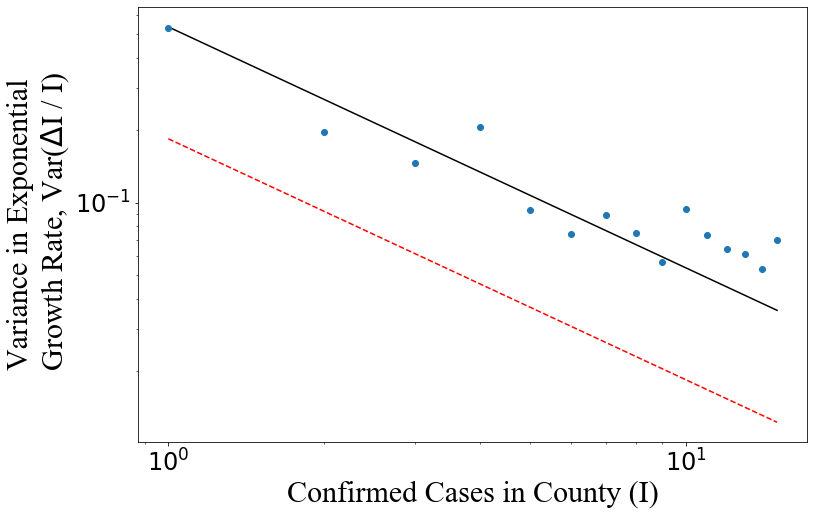

In [14]:
fig, ax = plt.subplots(1, 1,figsize=(12, 8))

ax.loglog(Is,(mu+v)/Is,'k-', label = r'$\frac{\mu_\beta+\sigma_\beta^2}{I}$')
ax.loglog(Is,mu/Is,'r--', label = r'$\frac{\mu_\beta+\sigma_\beta^2}{I}$')
ax.loglog(Is,var,'o', label = "USA Data")
ax.set_xlabel("Confirmed Cases in County (I)",fontsize = 30,fontname="Times New Roman")
ax.set_ylabel("Variance in Exponential\n Growth Rate, Var($\\Delta$I / I)",fontsize = 30,fontname="Times New Roman")
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(24) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(24) 

61.65194774732934
81.38940533263036
95.49851227580179


Text(0, 0.5, 'Cumulative Share of Infections Caused')

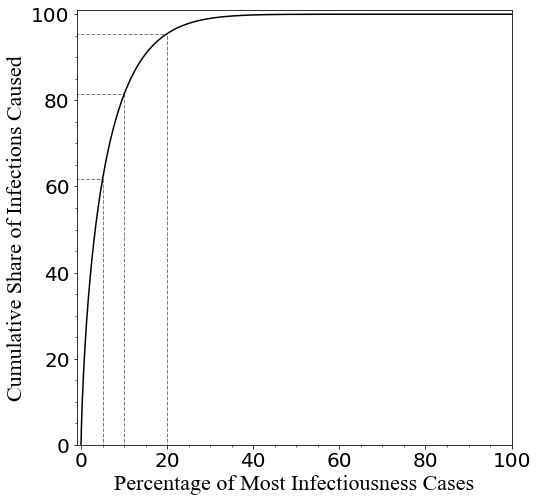

In [9]:
fig, ax = plt.subplots(1, 1,figsize=(12, 8))
ax.set_aspect(1)
for x in [5,10,20]:
    ax.plot([x,x],[-3,100*gammaincc(1+disp,gammainccinv(disp,x/100))],c='grey',ls='--', lw = 1)
    ax.plot([-10,x],[100*gammaincc(1+disp,gammainccinv(disp,x/100)),100*gammaincc(1+disp,gammainccinv(disp,x/100))],c='grey',ls='--', lw = 1)
x = np.linspace(0,1,1000)

ax.plot(x*100,100*gammaincc(1+disp,gammainccinv(disp,x)),'k',label = r"$\frac{\mu_k^2}{\sigma_k^2} = $ "+str(round(disp,3)))
print(100*gammaincc(1+disp,gammainccinv(disp,0.05)))
print(100*gammaincc(1+disp,gammainccinv(disp,0.10)))
print(100*gammaincc(1+disp,gammainccinv(disp,0.20)))
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20) 
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(-1,100)
ax.set_ylim(0,101)
ax.set_xlabel("Percentage of Most Infectiousness Cases",fontsize = 22,fontname = "Times New Roman")
ax.set_ylabel("Cumulative Share of Infections Caused",fontsize = 22,fontname = "Times New Roman")